# Data sets Carian and Jan

   Zeit  Butanal-200  Butyroin-200  Octandiol-200  Butanal-400  Butyroin-400  \
0     0    96.594128      0.146979       0.087363   132.846287      0.146979   
1    15    59.927461     44.956117       0.087363    37.146805     42.250977   
2    30    32.483592     52.241960       1.252210    22.656304     46.116321   
3    60    14.210708     50.035768       2.770671    11.930915     44.421100   
4   260     4.970639     52.109708       9.062923     3.416235     54.099489   

   Octandiol-400  
0       0.087363  
1       2.937077  
2       3.623505  
3      10.799792  
4      32.079043  
0       0
1      15
2      30
3      60
4     260
5     360
6    1440
Name: Zeit, dtype: int64


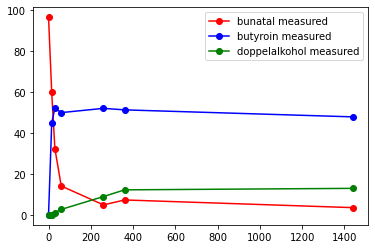

In [17]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Jan_Carina_Daten.xlsx")

print(df.head())

butanal = df["Butanal-200"]
butyroin = df["Butyroin-200"]
octandiol = df["Octandiol-200"]

time = df["Zeit"]

print(time)

fix, ax = plt.subplots()

ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="-", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="-", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="-", marker="o")
ax.legend()
plt.plot()
plt.show()


[[9.65941278e+01 5.99274611e+01 3.24835924e+01 1.42107081e+01
  4.97063903e+00 7.38860104e+00 3.64075993e+00]
 [1.46979261e-01 4.49561166e+01 5.22419597e+01 5.00357680e+01
  5.21097084e+01 5.13703036e+01 4.79558161e+01]
 [8.73634945e-02 8.73634945e-02 1.25221009e+00 2.77067083e+00
  9.06292252e+00 1.23286531e+01 1.30514821e+01]]
[100, 0, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 21
    # variables        = 4
    chi-square         = 5270.80237
    reduced chi-square = 310.047198
    Akaike info crit   = 124.033724
    Bayesian info crit = 128.211814
[[Variables]]
    kA:  2.95492208 +/- 2.69430490 (91.18%) (init = 2)
    kP:  1.1897e-09 +/- 4.3307e-04 (36402171.89%) (init = 2)
    kC:  0.04337041 +/- 1.37223737 (3163.99%) (init = 2)
    kD:  0.60311906 +/- 19.6034794 (3250.35%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kC, kD) = 0.998
    C(kA, kP) = -0.157
    C(kA, kD) = 0.153
    C(kA, kC

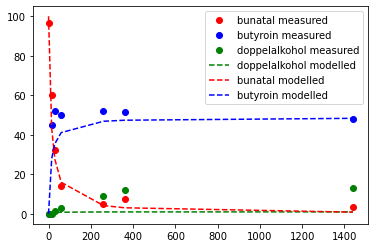

In [19]:
data_list = [butanal, butyroin, octandiol]

data = np.array(data_list)

print(data)


y0_array = [100, 0, 0]
print(y0_array)



def dbdt(kA, kB, kC, kD, A,P, C, t):
    if t <= 10:
        dbdt = (kA*A**2)*0.5 - kB*P
        return dbdt
    elif t >= 10:
        dbdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
        return dbdt
def dcdt(kC, kD, P, C, t):
    if t <= 10:
        return 0
    elif t >= 10:
        dcdt = kC*P - kD*C
        return dcdt




def dglsys(init_cond_array, t, kA, kB, kC, kD):
    A = init_cond_array[0]
    P = init_cond_array[1]
    C = init_cond_array[2]
    dAdt = -kA*A**2 + kB*P
    #dBdt = (kA*A**2)*0.5 - kB*P - kC*P + kD*C
    dBdt = dbdt(kA, kB, kC, kD, A, P, C, t)
    dCdt = dcdt(kC, kD, P, C, t)
    #dCdt = kC*P - kD*C
    dZdt = np.array([dAdt, dBdt, dCdt])
    return dZdt

sol = odeint(dglsys, y0_array, time, args=(0.000876, 0.00000473, 0.0032, 0.15))



params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)
params.add('kC', 2, min=0.0000000001, max=3)
params.add('kD', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    kC = params['kC'].value
    kD = params['kD'].value
    
    ymodel=odeint(dglsys, y0_array, time, args=(kA, kP, kC, kD))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    product2 = data_sets[2]-ymodel[:,2]
    result = [substr, product, product2] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
ax.plot(time, butanal, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time, butyroin, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.plot(time, octandiol, label="doppelalkohol measured", color="green", linestyle="", marker="o")

ax.plot(time, sol[:,2], label="doppelalkohol modelled", linestyle="--", color="green")
ax.plot(time, sol[:,0], label="bunatal modelled", linestyle="--", color="red")
ax.plot(time, sol[:,1], label="butyroin modelled", linestyle="--", color = "blue")


ax.legend()
plt.savefig("testfig.svg", format="svg")